# Imports and Data Frame Creation

In [122]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats.mstats import winsorize
import seaborn as sns
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import warnings
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set()
warnings.filterwarnings('ignore')

In [123]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy', con=engine)

engine.dispose()

# Understanding the Data

In [124]:
life_df.head(5)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [126]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [127]:
life_df.isnull().sum()*100 / life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

**Note:** Need to remove Hepatisis B, Population, and GDP features since there is a high percentage of null values. GDP and percentage expenditure have a high correlation and since GDP has a high percentage of nulls, it can be removed without a lot of loss. 

In [128]:
life_df = life_df.drop(columns = ['Hepatitis B', 'Population', 'GDP'])

## Removing White Space

In [129]:
life_df.rename(columns={" BMI ":"BMI",
                        "Life expectancy ":"Life_Expectancy",
                        "Measles ":"Measles",
                        " BMI ":"BMI",
                        "under-five deaths ":"under-five deaths",
                        "Diphtheria ":"Diphtheria",
                        " HIV/AIDS":"HIV/AIDS",
                        " thinness  1-19 years":"thinness  1-19 years",
                        " thinness 5-9 years":"thinness 5-9 years",
                        },inplace=True)

# Fill in Missing Data 

Since this data is specific to the country, it makes sense to fill in the missing data with an interpolation of that country's data. However, the missing data seems that we have, seems to be for the entire country, over multiple years. Therefore, interpolation has no effect. If this study were looking at the data by country status, it would make sense to fill in the missing data with a mean by that country status. However, since we are looking at this by country, and interpolation won't work, we will drop the missing data. 

In [130]:
#list of columns
fill_list = list(life_df.columns)

#list of countries
countries = life_df['Country'].unique()

In [131]:
#interpolation
for country in countries:
    life_df.loc[life_df['Country']==country] = life_df.loc[life_df['Country']==country].interpolate()

# drop missing values that are remaining
life_df.dropna(inplace = True)

life_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2567 entries, 0 to 2937
Data columns (total 19 columns):
Country                            2567 non-null object
Year                               2567 non-null int64
Status                             2567 non-null object
Life_Expectancy                    2567 non-null float64
Adult Mortality                    2567 non-null float64
infant deaths                      2567 non-null int64
Alcohol                            2567 non-null float64
percentage expenditure             2567 non-null float64
Measles                            2567 non-null int64
BMI                                2567 non-null float64
under-five deaths                  2567 non-null int64
Polio                              2567 non-null float64
Total expenditure                  2567 non-null float64
Diphtheria                         2567 non-null float64
HIV/AIDS                           2567 non-null float64
thinness  1-19 years               2567 non-null

# Look for Outliers

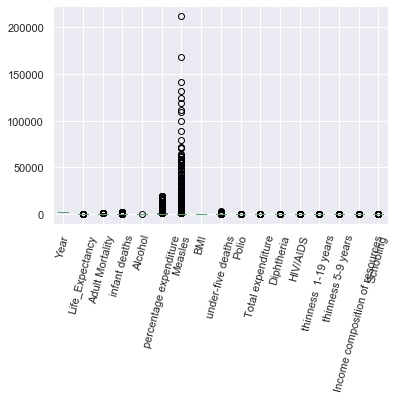

In [155]:
life_df.boxplot()
plt.xticks(rotation=75)
plt.show()

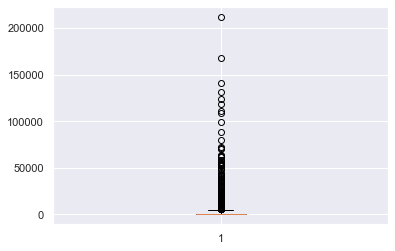

In [133]:
#Drill into Measles
plt.boxplot(life_df['Measles'], whis = 15)
plt.show()

In [134]:
life_df['Measles'].describe()

count      2567.000000
mean       2245.967667
std       10756.184222
min           0.000000
25%           0.000000
50%          14.000000
75%         337.500000
max      212183.000000
Name: Measles, dtype: float64

**Notes** Measles are explained in the dataset as the number of cases per 1000 in the population. However, there are many values well above 1000, with the highest being 212,200 and the average being 2245. Therefore, Measles will be taken out altogether.  

I then reviewed these further on Kaggle and found several of the data points to be unreliable data. Therefore, I have choosen to remove those features altogether (Measles, Under 5 deaths, Percentage Expenditure, BMI, and Infant Deaths). 

In [135]:
life_df2 = life_df.drop(columns = ['Measles', 'under-five deaths', 'percentage expenditure', 'BMI', 'infant deaths'])

## Review Other Outliers

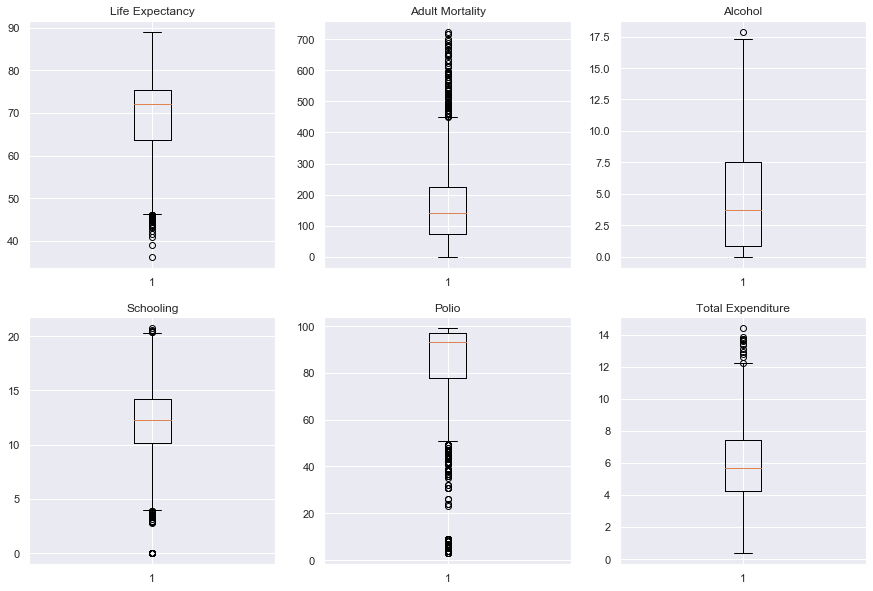

In [136]:
plt.figure(figsize = (15,10))

plt.subplot(2,3,1)
plt.boxplot(life_df2['Life_Expectancy'])
plt.title('Life Expectancy')

plt.subplot(2,3,2)
plt.boxplot(life_df2['Adult Mortality'])
plt.title('Adult Mortality')

plt.subplot(2,3,3)
plt.boxplot(life_df2['Alcohol'])
plt.title('Alcohol')

plt.subplot(2,3,4)
plt.boxplot(life_df2['Schooling'])
plt.title('Schooling')

plt.subplot(2,3,5)
plt.boxplot(life_df2['Polio'])
plt.title('Polio')

plt.subplot(2,3,6)
plt.boxplot(life_df2['Total expenditure'])
plt.title('Total Expenditure')

plt.show()

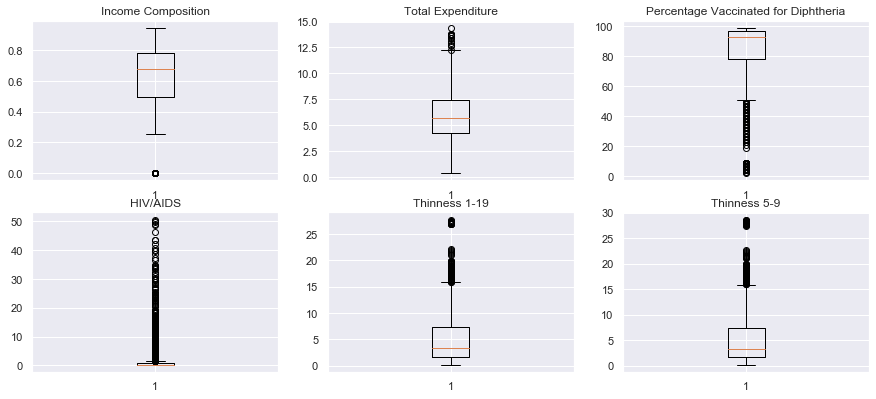

In [137]:
plt.figure(figsize = (15,10))

plt.subplot(3,3,1)
plt.boxplot(life_df2['Income composition of resources'])
plt.title('Income Composition')

plt.subplot(3,3,2)
plt.boxplot(life_df2['Total expenditure'])
plt.title('Total Expenditure')

plt.subplot(3,3,3)
plt.boxplot(life_df2['Diphtheria'])
plt.title('Percentage Vaccinated for Diphtheria')

plt.subplot(3,3,4)
plt.boxplot(life_df2['HIV/AIDS'])
plt.title('HIV/AIDS')

plt.subplot(3,3,5)
plt.boxplot(life_df2['thinness  1-19 years'])
plt.title('Thinness 1-19')

plt.subplot(3,3,6)
plt.boxplot(life_df2['thinness 5-9 years'])
plt.title('Thinness 5-9')

plt.show()

### Reviewing Vaccination Low Values for High Life Expectancy

In [156]:
life_over_70 = life_df2.loc[life_df2['Life_Expectancy'] > 70]

life_over_70.loc[life_over_70['Adult Mortality'] < 100]
life_over_70.loc[life_over_70['Diphtheria'] < 20]
life_over_70.loc[life_over_70['Polio'] < 20]

,Country,Year,Status,Life_Expectancy,Adult Mortality,Alcohol,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
105,Armenia,2007,Developing,73.5,132.0,3.990,9.0,4.31,88.0,0.1,2.0,2.1,0.707,11.7
128,Australia,2000,Developed,79.5,78.0,10.170,9.0,8.80,9.0,0.1,0.7,0.7,0.897,20.4
214,Barbados,2010,Developing,74.7,16.0,8.410,9.0,6.17,86.0,0.1,3.8,3.8,0.781,15.8
221,Barbados,2003,Developing,73.7,121.0,7.650,9.0,5.82,89.0,0.4,4.1,4.1,0.753,14.2
326,Bosnia and Herzegovina,2010,Developing,76.4,94.0,4.540,9.0,9.58,89.0,0.1,2.6,2.6,0.717,13.3
327,Bosnia and Herzegovina,2009,Developing,76.1,97.0,4.750,9.0,9.64,9.0,0.1,2.7,2.7,0.716,13.3
452,Cabo Verde,2011,Developing,72.6,122.0,5.070,9.0,4.60,9.0,0.3,7.3,7.2,0.632,13.1
504,Canada,2007,Developing,85.0,74.0,8.300,9.0,9.83,94.0,0.1,0.5,0.4,0.894,15.8
546,Chile,2013,Developing,81.0,84.0,7.200,9.0,7.53,91.0,0.1,0.8,0.8,0.831,15.6
547,Chile,2012,Developing,79.9,84.0,6.760,9.0,7.24,9.0,0.1,0.8,0.8,0.826,15.5


In [139]:
#winsorizing adult mortality, dipteria, and polio because it seems 
#like some of the low numbers may be in error. Based on te charts above
#as well as a search through WHO and countries that get those vaccines.
life_df3 = life_df2.copy()
life_df3['Adult Mortality'] = winsorize(life_df2['Adult Mortality'],(.05,.05))
life_df3['Diphtheria'] = winsorize(life_df2['Diphtheria'],(.05,.05))
life_df3['Polio'] = winsorize(life_df2['Polio'],(.05,.05))

**Note:** I am going to leave the remaining outliers since these may have a significant impact on life expectancy. 

# Explore the data using univariate and multivariate exploration techniques

In [143]:
#get univariate statistics
life_df3.describe()

,Year,Life_Expectancy,Adult Mortality,Alcohol,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000,2567.000000
mean,2007.006233,69.328516,156.898325,4.536422,82.697702,5.870016,82.614725,1.830697,4.907285,4.945656,0.627196,12.032918
std,4.325417,9.384865,107.969530,4.012325,22.990504,2.373507,23.195986,5.364224,4.505165,4.596712,0.210212,3.250390
min,2000.000000,36.300000,12.000000,0.010000,9.000000,0.370000,9.000000,0.100000,0.100000,0.100000,0.000000,0.000000
25%,2003.000000,63.700000,73.000000,0.845000,78.000000,4.260000,78.000000,0.100000,1.600000,1.600000,0.494000,10.100000
50%,2007.000000,72.200000,142.000000,3.750000,93.000000,5.710000,93.000000,0.100000,3.300000,3.300000,0.677000,12.300000
75%,2011.000000,75.400000,223.500000,7.525000,97.000000,7.455000,97.000000,0.700000,7.300000,7.300000,0.778500,14.200000
max,2015.000000,89.000000,395.000000,17.870000,99.000000,14.390000,99.000000,50.600000,27.700000,28.600000,0.945000,20.700000


## Univariate Method to Check for Normalization Visually

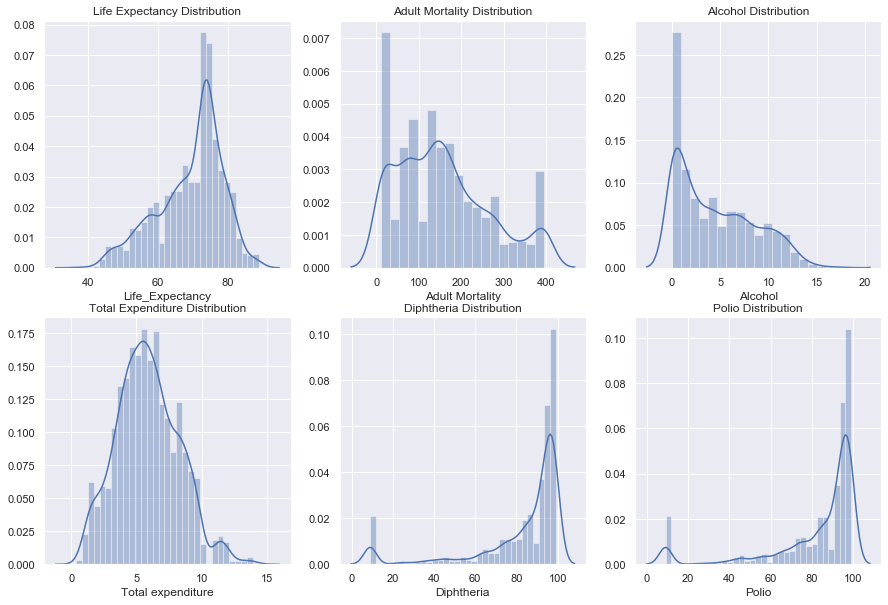

In [144]:
plt.figure(figsize = (15,10))

plt.subplot(2,3,1)
sns.distplot(life_df3['Life_Expectancy'])
plt.title('Life Expectancy Distribution')

plt.subplot(2,3,2)
sns.distplot(life_df3['Adult Mortality'])
plt.title('Adult Mortality Distribution')

plt.subplot(2,3,3)
sns.distplot(life_df3['Alcohol'])
plt.title('Alcohol Distribution')

plt.subplot(2,3,4)
sns.distplot(life_df3['Total expenditure'])
plt.title('Total Expenditure Distribution')

plt.subplot(2,3,5)
sns.distplot(life_df3['Diphtheria'])
plt.title('Diphtheria Distribution')

plt.subplot(2,3,6)
sns.distplot(life_df3['Polio'])
plt.title('Polio Distribution')

plt.show()

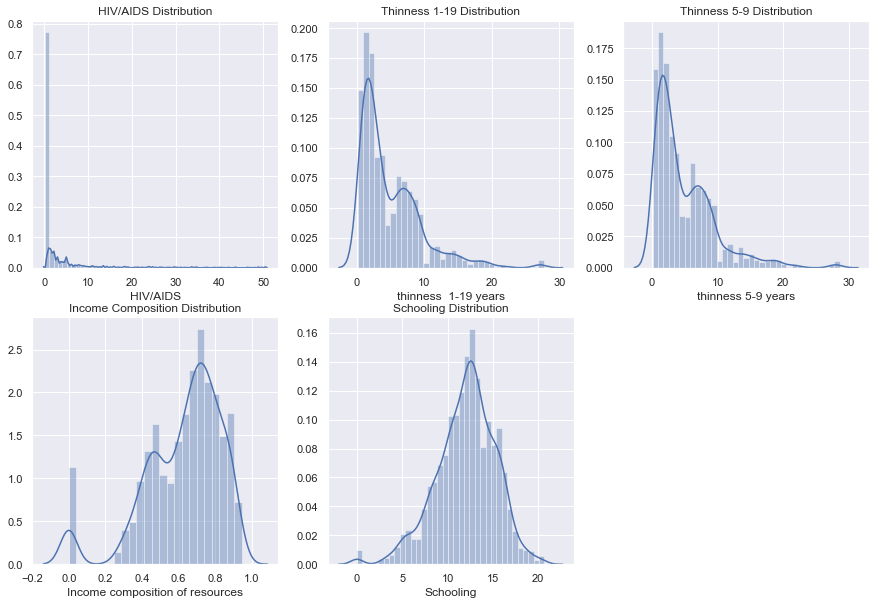

In [145]:
plt.figure(figsize = (15,10))

plt.subplot(2,3,1)
sns.distplot(life_df3['HIV/AIDS'])
plt.title('HIV/AIDS Distribution')

plt.subplot(2,3,2)
sns.distplot(life_df3['thinness  1-19 years'])
plt.title('Thinness 1-19 Distribution')

plt.subplot(2,3,3)
sns.distplot(life_df3['thinness 5-9 years'])
plt.title('Thinness 5-9 Distribution')

plt.subplot(2,3,4)
sns.distplot(life_df3['Income composition of resources'])
plt.title('Income Composition Distribution')

plt.subplot(2,3,5)
sns.distplot(life_df3['Schooling'])
plt.title('Schooling Distribution')

plt.show()

**Note:** Going to need to normalize and scale many of these before putting into a model. 

## Univariate visualization of categorical variables


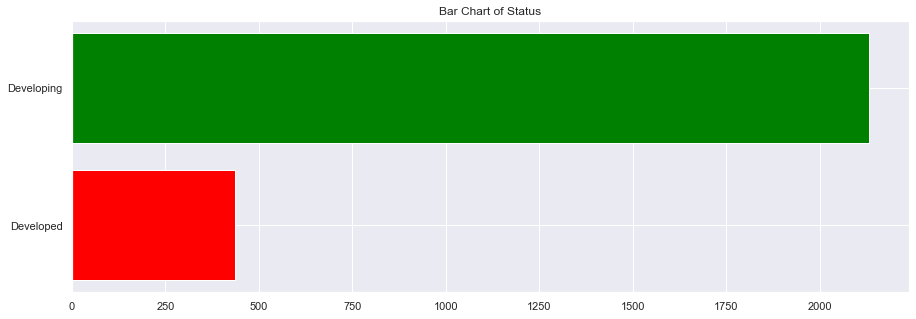

In [146]:
# bar chart of Status
plt.figure(figsize=(15,5))
plt.barh(life_df3.groupby("Status")["Status"].count().index, 
        life_df3.groupby("Status")["Status"].count(), 
        color=["red","green"])
plt.title("Bar Chart of Status")

plt.show()

## Bivariate Analysis of Continuous-Categorical Pair

In [147]:
life_df3['Life_Expectancy'].groupby(life_df3['Status']).agg(['mean', 'median', 'max', 'min'])

,mean,median,max,min
Status,,,,
Developed,79.162989,79.4,89.0,69.9
Developing,67.321951,69.4,89.0,36.3


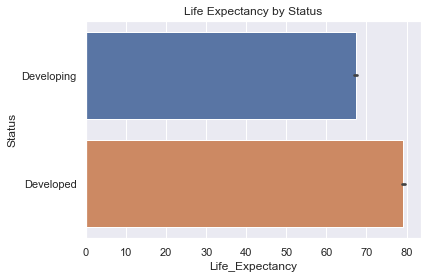

In [148]:
sns.barplot(life_df3['Life_Expectancy'], life_df3['Status'])
plt.title('Life Expectancy by Status')
plt.show()

## Check for Correlations

In [149]:
life_df3.corr()

,Year,Life_Expectancy,Adult Mortality,Alcohol,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1.000000,0.162946,-0.056902,-0.049497,0.104407,0.083260,0.158570,-0.127427,-0.035666,-0.040668,0.237305,0.212824
Life_Expectancy,0.162946,1.000000,-0.659789,0.379524,0.443908,0.191072,0.454125,-0.571308,-0.464434,-0.459016,0.710805,0.745369
Adult Mortality,-0.056902,-0.659789,1.000000,-0.183920,-0.266755,-0.119102,-0.260450,0.407273,0.302449,0.309456,-0.459908,-0.470359
Alcohol,-0.049497,0.379524,-0.183920,1.000000,0.208409,0.289014,0.208027,-0.039608,-0.417334,-0.405039,0.448373,0.546404
Polio,0.104407,0.443908,-0.266755,0.208409,1.000000,0.128459,0.688622,-0.157094,-0.210508,-0.212572,0.386313,0.426493
Total expenditure,0.083260,0.191072,-0.119102,0.289014,0.128459,1.000000,0.135716,0.017202,-0.260228,-0.267519,0.164902,0.262073
Diphtheria,0.158570,0.454125,-0.260450,0.208027,0.688622,0.135716,1.000000,-0.163369,-0.217737,-0.210988,0.406785,0.432822
HIV/AIDS,-0.127427,-0.571308,0.407273,-0.039608,-0.157094,0.017202,-0.163369,1.000000,0.198278,0.201999,-0.247062,-0.224630
thinness 1-19 years,-0.035666,-0.464434,0.302449,-0.417334,-0.210508,-0.260228,-0.217737,0.198278,1.000000,0.936855,-0.419090,-0.475910
thinness 5-9 years,-0.040668,-0.459016,0.309456,-0.405039,-0.212572,-0.267519,-0.210988,0.201999,0.936855,1.000000,-0.407331,-0.464463


Text(0.5, 1, 'Correlation Matrix (Life Expectancy)')

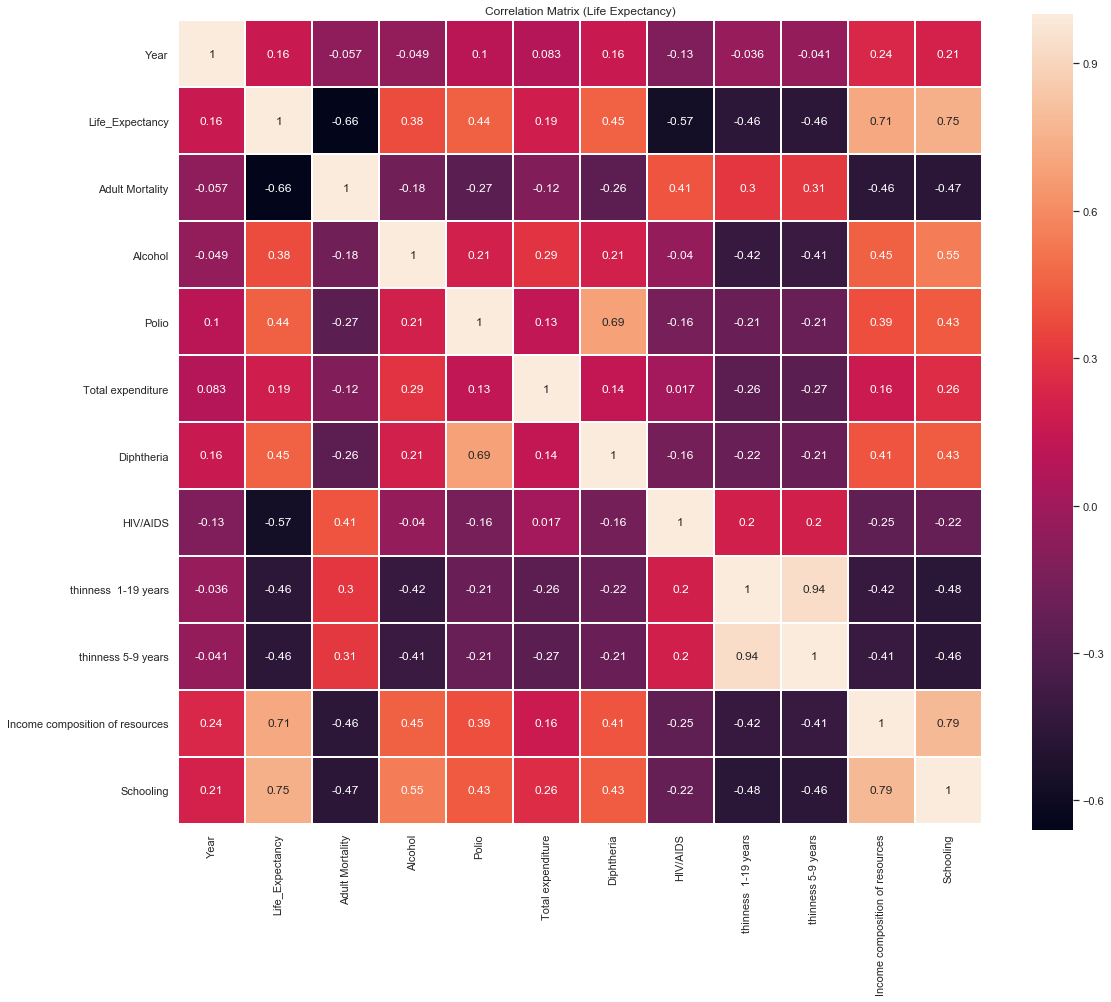

In [150]:
plt.figure(figsize=(18,15))
corrmat_life = life_df3.corr()

sns.heatmap(corrmat_life, square = True, annot = True, linewidths=.5)
plt.title('Correlation Matrix (Life Expectancy)')

**Note:** Schooling and income composition have a high correlation to life expectancy (above 70%). Therefore, they will be removed.

Thinness 1-19 years and thinness 5-9 years have a correlation of .94, therefore, thinness 5-9 years will be removed.

In [151]:
life_df4 = life_df3.drop(columns = ['Income composition of resources', 'Schooling', 'thinness 5-9 years'])

## View Relationships Grapically 

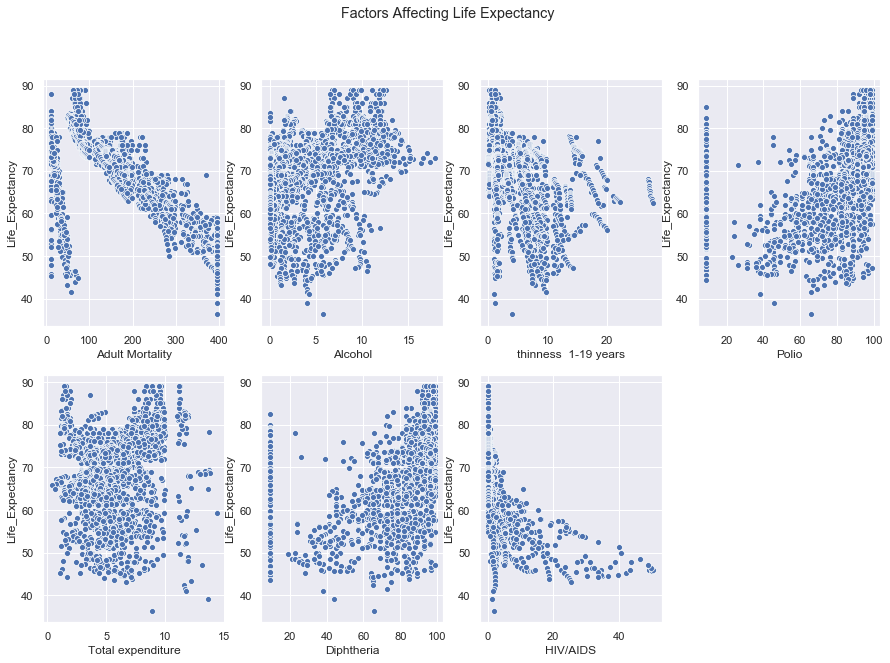

In [152]:
plt.figure(figsize=(15,10))

plt.subplot(2,4,1)
sns.scatterplot(x = life_df4['Adult Mortality'], y = life_df4['Life_Expectancy'])

plt.subplot(2,4,2)
sns.scatterplot(x = life_df4['Alcohol'], y = life_df4['Life_Expectancy'])

plt.subplot(2,4,3)
sns.scatterplot(x = life_df4['thinness  1-19 years'], y = life_df4['Life_Expectancy'])

plt.subplot(2,4,4)
sns.scatterplot(x = life_df4['Polio'], y = life_df4['Life_Expectancy'])

plt.subplot(2,4,5)
sns.scatterplot(x = life_df4['Total expenditure'], y = life_df4['Life_Expectancy'])

plt.subplot(2,4,6)
sns.scatterplot(x = life_df4['Diphtheria'], y = life_df4['Life_Expectancy'])

plt.subplot(2,4,7)
sns.scatterplot(x = life_df4['HIV/AIDS'], y = life_df4['Life_Expectancy'])

plt.suptitle('Factors Affecting Life Expectancy')
plt.show()


## Conclusion

As seen in the graphs above, there is a relationship between life expectancy and most of the above factors. 

**Factors that increase life expectancy:** Alcohol, Polio Vaccination, Diphtheria Vaccination, and Total Expenditure.

**Factors that decrease life expectancy:** Adult Mortality, Thinness, and HIV/AIDS. 

There are the strong relationships between Life Expectancy and  vaccination rates, and HIV/AIDS. 

The data has been cleaned is ready to be finally prepped for a model. The final stages would include scaling and normalizing the data, converting categorical data (one hot encoding), PCA and/or SelectKBest to narrow down features. 

It may also be wise to look further into Adult Mortality, Polio, and Diphtheria low values. They have been winsorized, but they maybe should be removed altogether if it is bad data. 

## Other Options

### Use SelectKBest to Determine Best Features or PCA

In [153]:
from sklearn.feature_selection import SelectKBest, f_classif 

Y = life_df4['Life_Expectancy']
X = life_df4.drop(['Life_Expectancy', 'Country', 'Status'], axis=1)
k = 5 
kbest = SelectKBest(k=k, score_func= f_classif) 
X_best_feature = kbest.fit_transform(X,Y) 
X_best_feature = pd.DataFrame(X_best_feature, columns = X.columns[kbest.get_support()]) 


X_best_feature.head()
kbest.scores_

X_best_feature.columns

Index(['Adult Mortality', 'Polio', 'Diphtheria', 'HIV/AIDS',
       'thinness  1-19 years'],
      dtype='object')

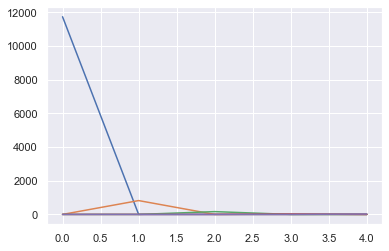

In [154]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5) 
X_pca = pca.fit_transform(X) 
cov = np.cov(X_pca.T)
plt.plot(cov);